# SVM (Support Vector Machine - Máquina de Vetores de Suporte)

Uma máquina de vetores de suporte (SVM, do inglês: support vector machine) é um conjunto de métodos de aprendizado supervisionado que analisam os dados e reconhecem padrões, usado para classificação e análise de regressão. O SVM padrão toma como entrada um conjunto de dados e prediz, para cada entrada dada, qual de duas possíveis classes a entrada faz parte, o que faz do SVM um classificador linear binário não probabilístico.

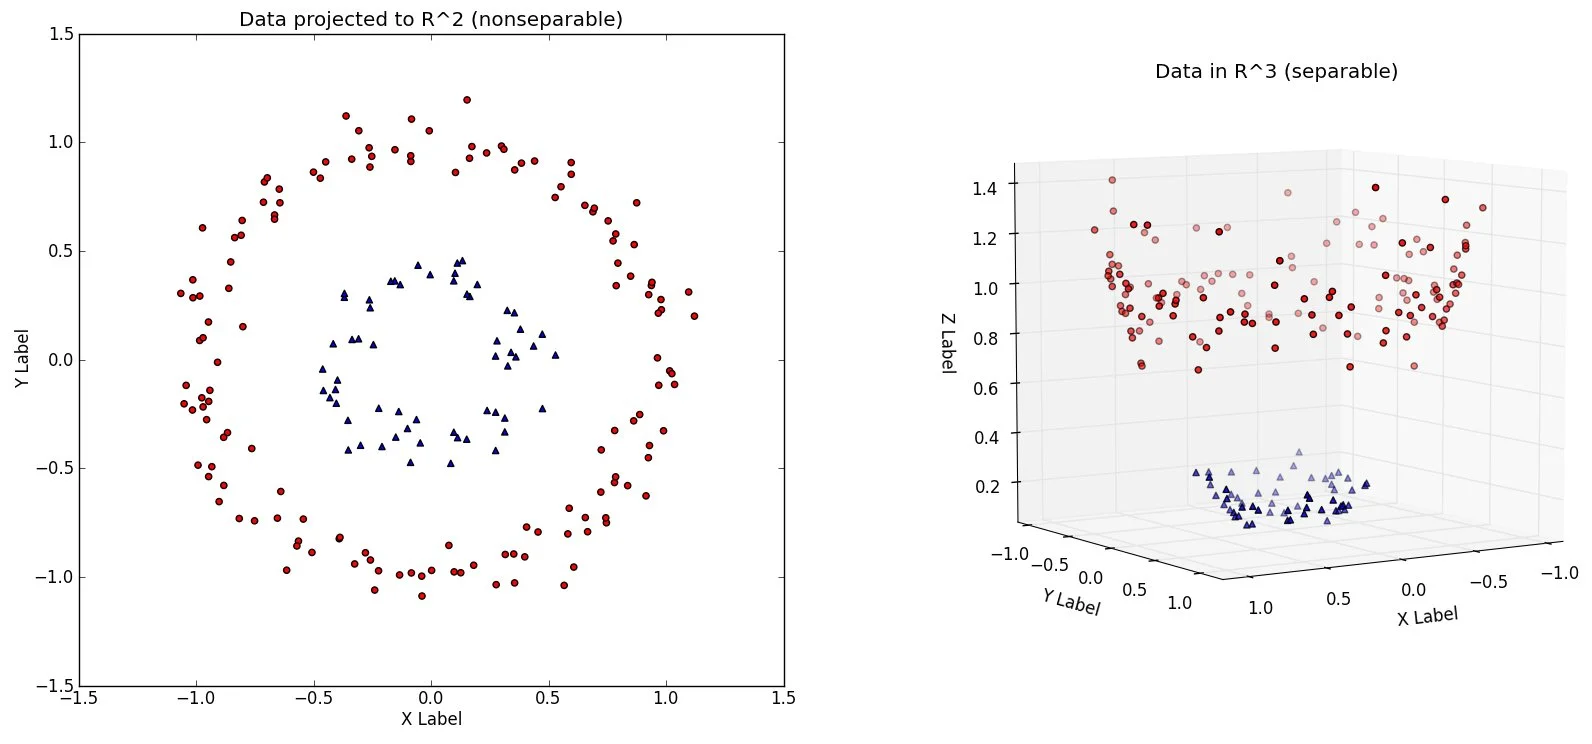

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
    
# from tqdm import tqdm
from tqdm.notebook import tqdm

## Carregando Base de Dados

In [2]:
!rm -r MLUD
!git clone https://github.com/Crissky/MLUD.git

Cloning into 'MLUD'...
remote: Enumerating objects: 314, done.
remote: Counting objects: 100% (314/314), done.
remote: Compressing objects: 100% (298/298), done.
remote: Total 314 (delta 138), reused 62 (delta 6), pack-reused 0
Receiving objects: 100% (314/314), 3.81 MiB | 11.84 MiB/s, done.
Resolving deltas: 100% (138/138), done.


## Funções de Pré-Processamento

Nessa aula, o vídeo mudou a maneira como são criadas as funções "Compute ‘método’ Model" e "Compute ‘método’ Example". Para facilitar a construção das funções, que são muito semelhantes, foi usada a abordagem de Orientação a Objetos.

No vídeo não é utilizado herança efetivamente, pois ele usa as funções diretamente da Classe que seria a “PAI” no lugar no “self” ou “super()” para evitar a necessidade de instância-lá.

Eu optei por usar as instâncias para realmente utilizar a herança. Outra mudança que fiz foi colocar a função “Compute Example” na Classe Pai (Classification Model), pois nos casos da Regressão Logística e do KNN, elas são idênticas.

Já a Classe do SVM precisa reescrever a função “Compute Example”, pois sua função “Compute Model” tem um argumento a mais, sendo que a “Compute Example” chama a “Compute Model”.


In [3]:
def loadDataset(filename, delimiter=';'):
    baseDeDados = pd.read_csv(filename, delimiter=delimiter)
    X = baseDeDados.iloc[:,:-1].values
    y = baseDeDados.iloc[:,-1].values

    return X, y, baseDeDados

def fillMissingData(X, inicioColuna, fimColuna):
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    X[:,inicioColuna:fimColuna + 1] = imputer.fit_transform(X[:,inicioColuna:fimColuna + 1])

    return X

#só funciona se i = 0 ou i = ultima coluna
def computeCategorization(X):
    labelencoder_X = LabelEncoder()
    X[:, 0] = labelencoder_X.fit_transform(X[:, 0])

    #one hot encoding
    D = pd.get_dummies(X[:,0]).values
    
    X = X[:,1:]
    for ii in range(0, D.shape[1]):
        X = np.insert(X, X.shape[1], D[:,ii], axis=1)
    X = X[:,:X.shape[1] - 1]

    return X

def splitTrainTestSets(X, y, testSize):
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = testSize)

    return XTrain, XTest, yTrain, yTest

def computeScaling(X):
    scale = StandardScaler()
    X = scale.fit_transform(X)

    return X, scale

In [4]:
def printAccuracy(confunsionMatrix):
    accuracy = getAccuracy(confunsionMatrix)
    print('Confusion Matrix:\n', confunsionMatrix)
    print('Accuracy:', accuracy)

def getAccuracy(confunsionMatrix):
    accuracy = (confunsionMatrix[0][0] + confunsionMatrix[1][1])/ confunsionMatrix.sum()

    return (accuracy * 100)

In [5]:
class ClassificationModel:
    def predictModel(self, classifier, X):
        return classifier.predict(X)

    def evaluateModel(self, yPred, yTest):
        confusionMatrix = confusion_matrix(yTest, yPred)

        return confusionMatrix

    def preprocessData(self, filename, delimiter=','):
        X, y, csv = loadDataset(filename, delimiter)
        X = fillMissingData(X, 2, 3)
        X = computeCategorization(X)
        X = computeCategorization(X)
        XTrain, XTest, yTrain, yTest = splitTrainTestSets(X, y, 0.15)
        XTrain, XTrainScale = computeScaling(XTrain) # No vídeo está recebendo a tupla em uma única variável. Fazendo com que no classifier.fit, da função computeLogisticRegressionModel, o XTrain tenha que se passado desta maneira XTrain[0]
        XTest, XTestScale = computeScaling(XTest)

        return XTrain, XTest, yTrain, yTest, XTrainScale, XTestScale
    
    def computeModel(self, XTrain, yTrain):
        pass

    def computeExample(self, filename, delimiter=','):
        XTrain, XTest, yTrain, yTest, XTrainScale, XTestScale = self.preprocessData(filename, delimiter)

        classifier = self.computeModel(XTrain, yTrain)
        yPred = self.predictModel(classifier, XTest)

        return self.evaluateModel(yPred, yTest)

## Regressão Logística

In [6]:
class MyLogisticRegression(ClassificationModel):
    def computeModel(self, XTrain, yTrain):
        classifier = LogisticRegression(solver='lbfgs')
        classifier.fit(XTrain, yTrain)
        
        return classifier

## K-NN

In [7]:
class KNN(ClassificationModel):
    def computeModel(self, XTrain, yTrain):
        classifier = KNeighborsClassifier(n_neighbors=5, p=1)
        classifier.fit(XTrain, yTrain)
    
        return classifier

## SVM

In [8]:
class SVM(ClassificationModel):
    def computeModel(self, XTrain, yTrain, k, d=0):
        if (d <= 0):
            classifier = SVC(kernel=k)
        else:
            classifier = SVC(kernel=k, degree=d)
        classifier.fit(XTrain, yTrain)

        return classifier

    def computeExample(self, filename, kernel='linear', degree=0, delimiter=','):
        XTrain, XTest, yTrain, yTest, XTrainScale, XTestScale = self.preprocessData(filename, delimiter)

        classifier = self.computeModel(XTrain, yTrain, kernel, degree)
        yPred = self.predictModel(classifier, XTest)

        return self.evaluateModel(yPred, yTest)


## Comparando Regressão Logística, KNN e SVM

In [9]:
def running_testing(n_loop, class_model, class_arguments, class_name=None, ncols=500, verbose=True):
    array = list()
    model = class_model()
    if(not class_name):
        class_name = type(class_model()).__name__
    for i in tqdm(range(n_loop), desc=class_name, ncols=ncols):
        
        if(type(class_arguments) == tuple):
            confunsionMatrix = model.computeExample(*class_arguments)
        else:
            confunsionMatrix = model.computeExample(class_arguments)
        
        array.append(getAccuracy(confunsionMatrix))
    
    if(verbose):
        print('Média da %s: %.2f' % (class_name, np.mean(array) ) )
        print('Desvio Padrão da %s: %.2f\n' % (class_name, np.std(array) ) )        

    return array


In [10]:
total_loops = 10
ncols=500

rlArray = running_testing(total_loops, MyLogisticRegression, ('MLUD/Aula13/titanic.csv'), 'Regressão Linear', ncols)
knnArray = running_testing(total_loops, KNN, ('MLUD/Aula13/titanic.csv'), 'KNN', ncols)
svmLinearArray = running_testing(total_loops, SVM, ('MLUD/Aula13/titanic.csv','linear'), 'SVM Linear', ncols)
svmPoly3Array = running_testing(total_loops, SVM, ('MLUD/Aula13/titanic.csv', 'poly', 3), 'SVM Poly3', ncols)
svmPoly4Array = running_testing(total_loops, SVM, ('MLUD/Aula13/titanic.csv', 'poly', 4), 'SVM Poly4', ncols)
svmPoly5Array = running_testing(total_loops, SVM, ('MLUD/Aula13/titanic.csv', 'poly', 5), 'SVM Poly5', ncols)
svmGaussArray = running_testing(total_loops, SVM, ('MLUD/Aula13/titanic.csv', 'rbf'), 'SVM Gaussiana', ncols)


Média da Regressão Linear: 79.10
Desvio Padrão da Regressão Linear: 2.11




Média da KNN: 80.30
Desvio Padrão da KNN: 3.82




Média da SVM Linear: 77.84
Desvio Padrão da SVM Linear: 3.96




Média da SVM Poly3: 79.18
Desvio Padrão da SVM Poly3: 2.82




Média da SVM Poly4: 76.27
Desvio Padrão da SVM Poly4: 2.40




Média da SVM Poly5: 75.37
Desvio Padrão da SVM Poly5: 4.25




Média da SVM Gaussiana: 82.39
Desvio Padrão da SVM Gaussiana: 3.27



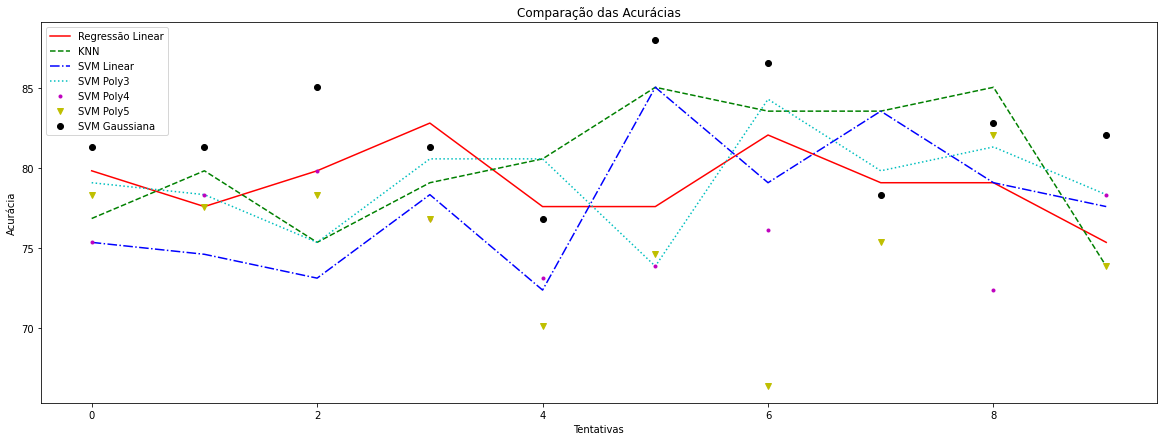

In [11]:
plt.figure(figsize=(20, 7))
plt.plot(rlArray, 'r-', label='Regressão Linear')
plt.plot(knnArray, 'g--', label='KNN')
plt.plot(svmLinearArray, 'b-.', label='SVM Linear')
plt.plot(svmPoly3Array, 'c:', label='SVM Poly3')
plt.plot(svmPoly4Array, 'm.', label='SVM Poly4')
plt.plot(svmPoly5Array, 'yv', label='SVM Poly5')
plt.plot(svmGaussArray, 'ko', label='SVM Gaussiana')
plt.xlabel('Tentativas')
plt.ylabel('Acurácia')
plt.title('Comparação das Acurácias')
plt.legend()
plt.show()

In [12]:
total_loops = 1000
ncols=500

rlArray = running_testing(total_loops, MyLogisticRegression, ('MLUD/Aula13/titanic.csv'), 'Regressão Linear', ncols)
knnArray = running_testing(total_loops, KNN, ('MLUD/Aula13/titanic.csv'), 'KNN', ncols)
svmGaussArray = running_testing(total_loops, SVM, ('MLUD/Aula13/titanic.csv', 'rbf'), 'SVM Gaussiana', ncols)


Média da Regressão Linear: 80.09
Desvio Padrão da Regressão Linear: 3.19




Média da KNN: 79.64
Desvio Padrão da KNN: 3.48




Média da SVM Gaussiana: 81.96
Desvio Padrão da SVM Gaussiana: 3.06



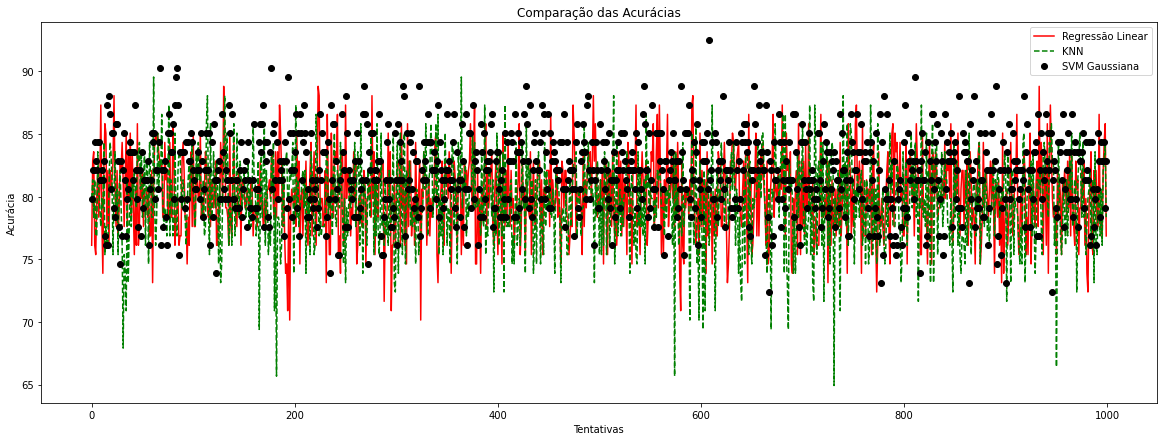

In [13]:
plt.figure(figsize=(20, 7))
plt.plot(rlArray, 'r-', label='Regressão Linear')
plt.plot(knnArray, 'g--', label='KNN')
plt.plot(svmGaussArray, 'ko', label='SVM Gaussiana')
plt.xlabel('Tentativas')
plt.ylabel('Acurácia')
plt.title('Comparação das Acurácias')
plt.legend()
plt.show()